In [1]:
#Dependencies 
import numpy as np
import pandas as pd
import requests
import time
import json
import datetime
#from us import states
from scipy.stats import linregress
import scipy.stats as st
from matplotlib import pyplot as plt
from glob import glob
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import wget

In [2]:
### BEGIN PALIDA's work on Covid Data ###
### Copying over from Palida's COVID_data_cleaning.ipynb ###

In [3]:
# url of the raw csv dataset
urls = [
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
]

# download data using wget function
[wget.download(url) for url in urls]

['time_series_covid19_confirmed_global (2).csv',
 'time_series_covid19_deaths_global (2).csv',
 'time_series_covid19_recovered_global (2).csv']

In [4]:
# load the data
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

# checking df
confirmed_df
deaths_df
recovered_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,24793,25180,25198,25358,25389,25471,25509,25509,25510,25669
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,2637,2682,2745,2789,2830,2883,2952,2961,3018,3031
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,18076,18088,18837,19233,19592,20082,20537,20988,21419,21901
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,803,803,803,803,804,806,807,807,807,821
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,242,242,242,266,301,395,437,460,461,476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,NaN,Sao Tome and Principe,0.186400,6.613100,0,0,0,0,0,0,...,662,696,734,759,766,771,778,782,787,787
249,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,780,797,833,840,849,856,862,862,862,863
250,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,324,328,328,328,330,330,330,330,330,330
251,NaN,Tajikistan,38.861000,71.276100,0,0,0,0,0,0,...,5906,5970,6028,6065,6103,6151,6193,6233,6276,6317


In [5]:
# extracting all of the dates columns
dates = confirmed_df.columns[4:]

# merging all of the confitmed, deaths, and recovered cases using melt function
# at this step we are using province, country, lat, and long as variables for merging
confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed'
)
deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths'
)
recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered'
)

# checking the dataframe
confirmed_df_long
deaths_df_long
recovered_df_long

,Province/State,Country/Region,Lat,Long,Date,Recovered
0,NaN,Afghanistan,33.939110,67.709953,1/22/20,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0
...,...,...,...,...,...,...
49330,NaN,Sao Tome and Principe,0.186400,6.613100,8/3/20,787
49331,NaN,Yemen,15.552727,48.516388,8/3/20,863
49332,NaN,Comoros,-11.645500,43.333300,8/3/20,330
49333,NaN,Tajikistan,38.861000,71.276100,8/3/20,6317


In [6]:
# removing Canada data because it was noted in the datasource about the data mismatched
recovered_df_long = recovered_df_long[recovered_df_long['Country/Region']!='Canada']

# merging two variables at a time
full_table = confirmed_df_long.merge(
  right=deaths_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

# merging again with recovered data
full_table = full_table.merge(
  right=recovered_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

# create tracker for active case (active - confirmed - death - recovered)
full_table['Active'] = full_table["Confirmed"] - full_table['Deaths'] - full_table['Recovered']

# checking the df
full_table

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,NaN,Afghanistan,33.939110,67.709953,1/22/20,0,0,0.0,0.0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0,0.0,0.0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0,0.0,0.0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0,0.0,0.0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
51865,NaN,Sao Tome and Principe,0.186400,6.613100,8/3/20,874,15,787.0,72.0
51866,NaN,Yemen,15.552727,48.516388,8/3/20,1734,499,863.0,372.0
51867,NaN,Comoros,-11.645500,43.333300,8/3/20,386,7,330.0,49.0
51868,NaN,Tajikistan,38.861000,71.276100,8/3/20,7538,61,6317.0,1160.0


In [7]:
# convert date to date time
full_table["Date"] = pd.to_datetime(full_table['Date'])
full_table

# replacing N/A
full_table['Recovered'] = full_table['Recovered'].fillna(0)

In [8]:
# grouping data by setting index and summing
full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [9]:
full_grouped

,Date,Country/Region,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Afghanistan,0,0,0.0,0.0
1,2020-01-22,Albania,0,0,0.0,0.0
2,2020-01-22,Algeria,0,0,0.0,0.0
3,2020-01-22,Andorra,0,0,0.0,0.0
4,2020-01-22,Angola,0,0,0.0,0.0
...,...,...,...,...,...,...
36655,2020-08-03,West Bank and Gaza,12541,84,5390.0,7067.0
36656,2020-08-03,Western Sahara,10,1,8.0,1.0
36657,2020-08-03,Yemen,1734,499,863.0,372.0
36658,2020-08-03,Zambia,6580,171,4701.0,1708.0


In [17]:
full_grouped.to_csv('../project_data/covid_data/COVID-19-time-series-clean-complete.csv')

In [18]:
### BEGIN PALIDA's work on Global Covid Data Processing ###
### Copying over from Palida's COVID_data_processing (Global).ipynb ###

In [19]:
%matplotlib notebook
#Dependencies 
import numpy as np
import pandas as pd
import requests
import time
import json
from scipy.stats import linregress
import scipy.stats as sts
from matplotlib import pyplot as plt
import altair as alt

In [21]:
# Import and Load CSV

full_grouped = pd.read_csv("../project_data/covid_data/COVID-19-time-series-clean-complete.csv", parse_dates=['Date'], index_col='Country/Region')
full_grouped = full_grouped.reset_index()

# remove the duplicated ID column
del full_grouped['Unnamed: 0']
full_grouped

,Country/Region,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,2020-01-22,0,0,0.0,0.0
1,Albania,2020-01-22,0,0,0.0,0.0
2,Algeria,2020-01-22,0,0,0.0,0.0
3,Andorra,2020-01-22,0,0,0.0,0.0
4,Angola,2020-01-22,0,0,0.0,0.0
...,...,...,...,...,...,...
36655,West Bank and Gaza,2020-08-03,12541,84,5390.0,7067.0
36656,Western Sahara,2020-08-03,10,1,8.0,1.0
36657,Yemen,2020-08-03,1734,499,863.0,372.0
36658,Zambia,2020-08-03,6580,171,4701.0,1708.0


In [22]:
full_grouped = full_grouped[(full_grouped['Date'] > '2020-01-22') & (full_grouped['Date'] < '2020-06-30')]
full_grouped

,Country/Region,Date,Confirmed,Deaths,Recovered,Active
188,Afghanistan,2020-01-23,0,0,0.0,0.0
189,Albania,2020-01-23,0,0,0.0,0.0
190,Algeria,2020-01-23,0,0,0.0,0.0
191,Andorra,2020-01-23,0,0,0.0,0.0
192,Angola,2020-01-23,0,0,0.0,0.0
...,...,...,...,...,...,...
30075,West Bank and Gaza,2020-06-29,2185,5,447.0,1733.0
30076,Western Sahara,2020-06-29,10,1,8.0,1.0
30077,Yemen,2020-06-29,1128,304,432.0,392.0
30078,Zambia,2020-06-29,1568,22,1311.0,235.0


<IPython.core.display.Javascript object>


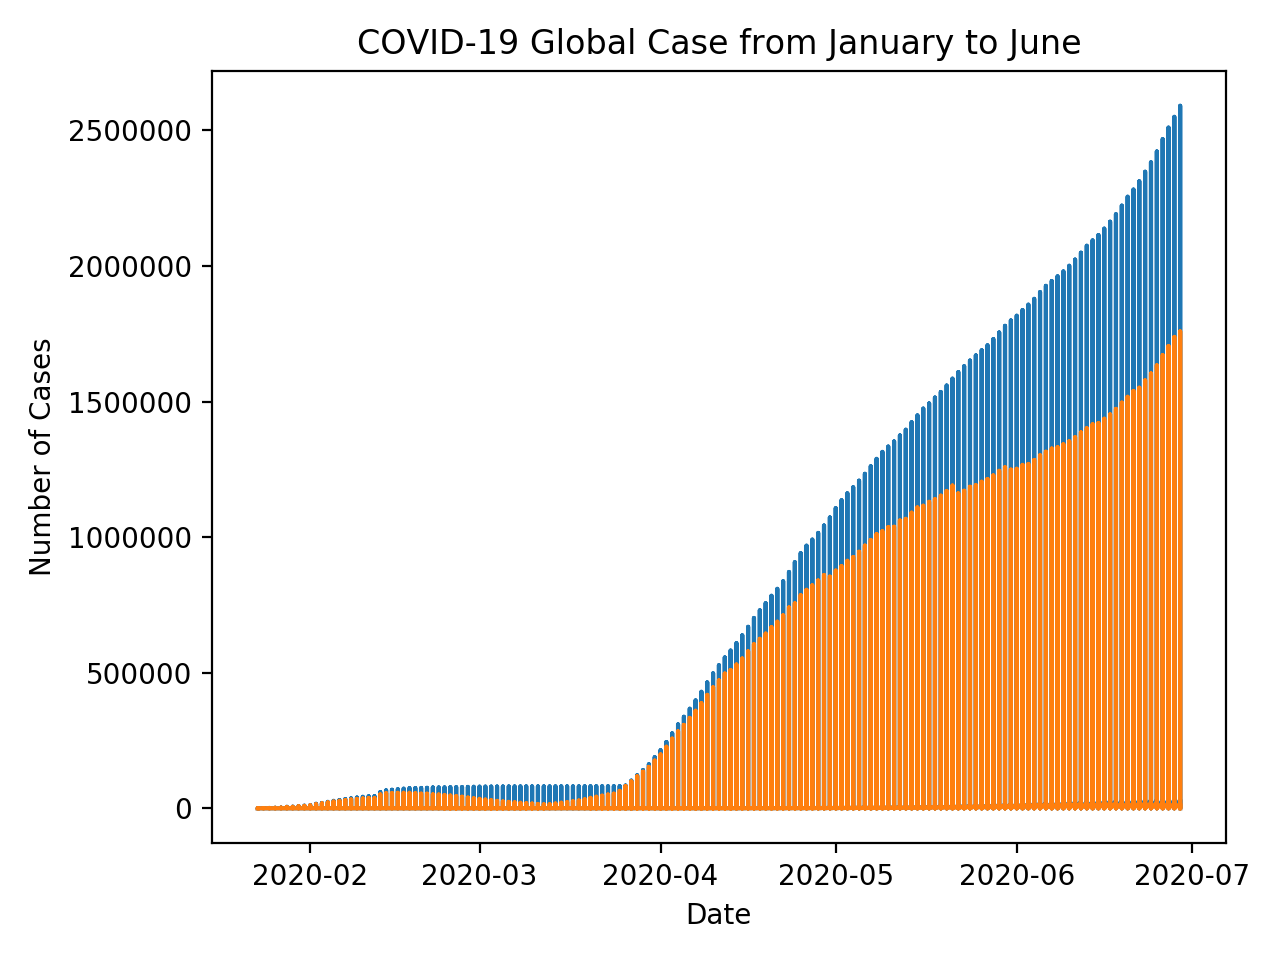

In [24]:
plt.plot(full_grouped['Date'],full_grouped['Confirmed'], label="Total Confirmed COVID-19 Case" )
plt.plot(full_grouped['Date'],full_grouped['Active'], label="Total Active COVID-19 Case" )
plt.title("COVID-19 Global Case from January to June")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.tight_layout()
plt.savefig("../images/covid_global.png")
plt.show()

In [ ]:
### BEGIN PALIDA's work on US Covid Data Processing ###
### Copying over from Palida's COVID_data_processing(US).ipynb ###

In [25]:
%matplotlib notebook
#Dependencies 
import numpy as np
import pandas as pd
import requests
import time
import json
from scipy.stats import linregress
import scipy.stats as sts
from matplotlib import pyplot as plt
import altair as alt

In [27]:
# Import and Load CSV

full_grouped_file = ("../project_data/covid_data/COVID-19-time-series-clean-complete.csv")

full_grouped_df = pd.read_csv(full_grouped_file)

full_grouped_df

# remove the duplicated ID column
del full_grouped_df['Unnamed: 0']
full_grouped_df

full_grouped_df = full_grouped_df[(full_grouped_df['Date'] > '2020-01-22') & (full_grouped_df['Date'] < '2020-06-31')]
full_grouped_df

us_case = full_grouped_df[full_grouped_df["Country/Region"] == "US"]
us_case


,Date,Country/Region,Confirmed,Deaths,Recovered,Active
362,2020-01-23,US,1,0,0.0,1.0
550,2020-01-24,US,2,0,0.0,2.0
738,2020-01-25,US,2,0,0.0,2.0
926,2020-01-26,US,5,0,0.0,5.0
1114,2020-01-27,US,5,0,0.0,5.0
...,...,...,...,...,...,...
29502,2020-06-26,US,2467554,125631,670809.0,1671114.0
29690,2020-06-27,US,2510259,126120,679308.0,1704831.0
29878,2020-06-28,US,2549864,126361,685164.0,1738339.0
30066,2020-06-29,US,2590668,126711,705203.0,1758754.0


In [28]:
#summary statistics
mean_numpy = np.mean(us_case)
mean_numpy

Confirmed    818659.21250
Deaths        45677.41875
Recovered    174513.36875
Active       598468.42500
dtype: float64

<IPython.core.display.Javascript object>


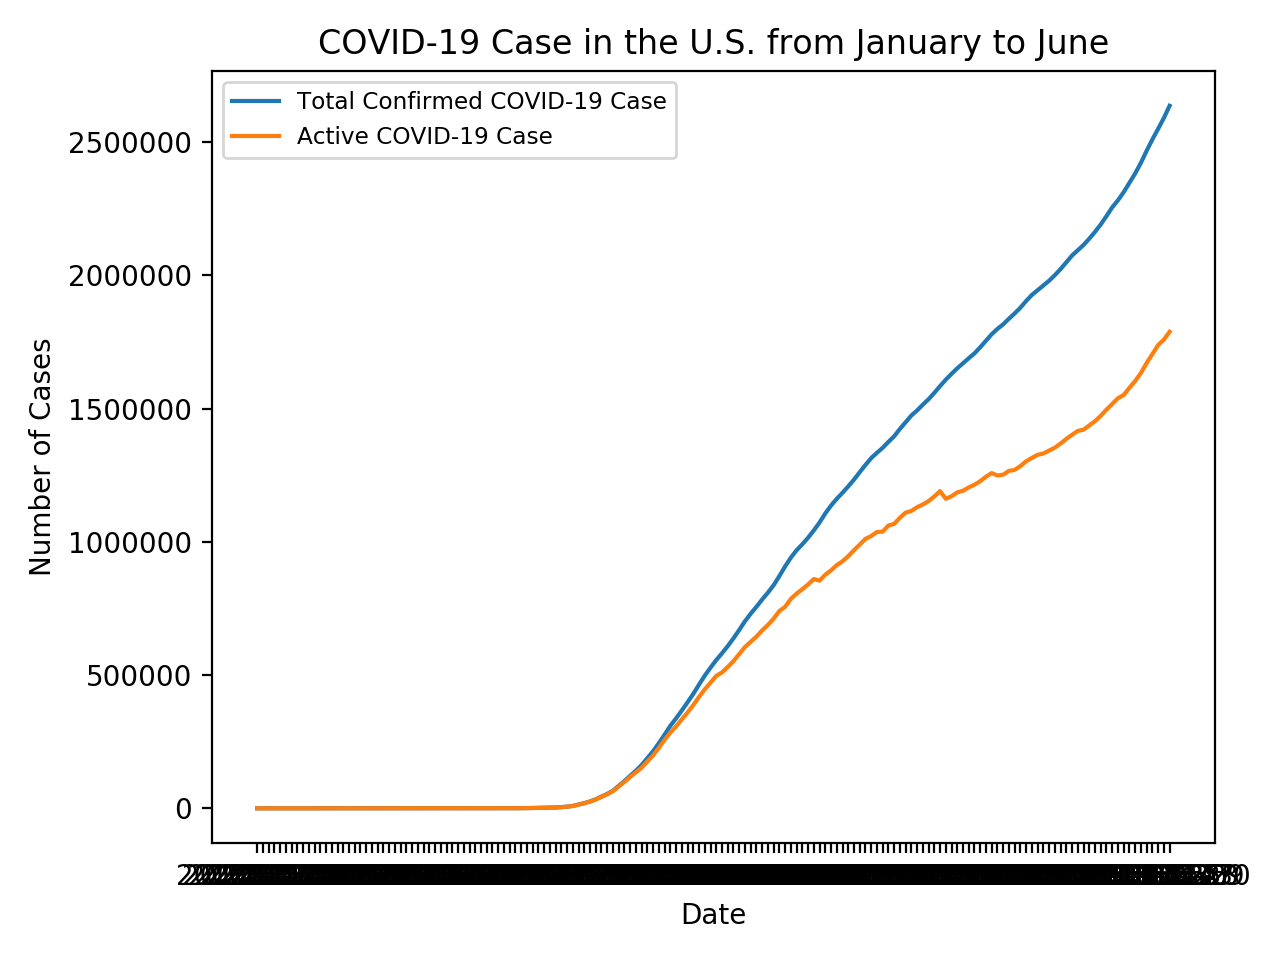

In [29]:
us_confirmed =plt.plot( us_case['Date'], us_case['Confirmed'], label="Total Confirmed COVID-19 Case" )
plt.title("COVID-19 Case in the U.S. from January to June")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.show() 

us_active = plt.plot( us_case['Date'], us_case['Active'], label="Active COVID-19 Case" )
plt.title("COVID-19 Case in the U.S. from January to June")
plt.xlabel("Date")
plt.ylabel("Number of Cases")

plt.legend(loc="best", fontsize="small", fancybox=True)
plt.tight_layout()
plt.savefig("../images/covid_us.png")
plt.show()

In [ ]:
# Save our graph and show the grap
#plt.tight_layout()
#plt.savefig("../Images/avg_state_rain.png")
#plt.show()

In [ ]:
### BEGIN Airport Data retrieval & clean ###

In [ ]:
#Airport Data 2016
airport_data_2016 = '../project_data/airline_data/TFMSC_Report_2016.csv'
df = pd.read_csv(airport_data_2016)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2016_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2016_df.head()

In [ ]:
#Airport Data 2017
airport_data_2017 = '../project_data/airline_data/TFMSC_Report_2017.csv'
df = pd.read_csv(airport_data_2017)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2017_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2017_df.head()

In [ ]:
#Airport Data 2018
airport_data_2018 = '../project_data/airline_data/TFMSC_Report_2018.csv'
df = pd.read_csv(airport_data_2018)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2018_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2018_df.head()

In [ ]:
#Airport Data 2019
airport_data_2019 = '../project_data/airline_data/TFMSC_Report_2019.csv'
df = pd.read_csv(airport_data_2019)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2019_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2019_df.head()

In [ ]:
#Airport Data 2020
airport_data_2020 = '../project_data/airline_data/TFMSC_Report_2020.csv'
df = pd.read_csv(airport_data_2020)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2020_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2020_df.head()

In [ ]:
#Combined Data for Airports
combined_airport = pd.concat([cleaned_2016_df,cleaned_2017_df,cleaned_2018_df,cleaned_2019_df,cleaned_2020_df])
combined_airport

In [ ]:
###BEGIN JAYDEN'S work on feb17 vs feb18 flight data###

In [ ]:
#FLU AIRPORT DATA#
combined_airport['Date'] = pd.to_datetime(combined_airport['Date'])
combined_airport

In [ ]:
#February 2017 Flight Data
start_2017 = '02-01-2017'
end_2017 = '02-28-2017'

#Mask date column to get range of data
mask = (combined_airport['Date'] > start_2017) & (combined_airport['Date'] <= end_2017)

#Create dataframe for February 2017 flights
february_airport_2017 = pd.DataFrame
february_airport_2017 = combined_airport.loc[mask]

# Total Departures for Atlanta
atlanta_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'ATL - Atlanta']
total_atl_flights_2017 = atlanta_flights['Departures'].sum()
print(total_atl_flights_2017)

#Total Departures for Dallas
dallas_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2017 = dallas_flights['Departures'].sum()
print(total_dallas_flights_2017)

#Total Departures for New York
newyork_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'JFK - New York']
total_newyork_flights_2017 = newyork_flights['Departures'].sum()
print(total_newyork_flights_2017)

#Total Departures for Los Angeles
losangeles_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2017 = losangeles_flights['Departures'].sum()
print(total_losangeles_flights_2017)

#Total Departures for Chicago
chicago_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'ORD - Chicago']
total_chicago_flights_2017 = chicago_flights['Departures'].sum()
print(total_chicago_flights_2017)

In [ ]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights_2017,total_dallas_flights_2017,total_newyork_flights_2017,total_losangeles_flights_2017,total_chicago_flights_2017]
total_departures_2017 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
total_departures_2017

In [ ]:
#March 2018 Flight Data
combined_airport
start_2018 = '02-01-2018'
end_2018 = '02-28-2018'
mask = (combined_airport['Date'] > start_2018) & (combined_airport['Date'] <= end_2018)
february_airport_2018 = pd.DataFrame
february_airport_2018 = combined_airport.loc[mask]
#february_airport_2018.groupby(['Airport'])
#february_airport_2018.head()

# Total Departures for Atlanta
atlanta_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'ATL - Atlanta']
total_atl_flights_2018 = atlanta_flights['Departures'].sum()
print(total_atl_flights_2018)

#Total Departures for Dallas
dallas_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2018 = dallas_flights['Departures'].sum()
print(total_dallas_flights_2018)

#Total Departures for New York
newyork_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'JFK - New York']
total_newyork_flights_2018 = newyork_flights['Departures'].sum()
print(total_newyork_flights_2018)

#Total Departures for Los Angeles
losangeles_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2018 = losangeles_flights['Departures'].sum()
print(total_losangeles_flights_2018)

#Total Departures for Chicago
chicago_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'ORD - Chicago']
total_chicago_flights_2018 = chicago_flights['Departures'].sum()
print(total_chicago_flights_2018)

In [ ]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights_2018,total_dallas_flights_2018,total_newyork_flights_2018,total_losangeles_flights_2018,total_chicago_flights_2018]
total_departures_2018 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
total_departures_2018

In [ ]:
#Merge 2017 and 2018 to create comparison bar graphs
merged_february_departures = pd.merge(total_departures_2017,total_departures_2018, how = 'inner', on='Airport')
merged_february_departures

#rename departure columns
merged_february_departures.rename(columns={'Departures_x': '2017_Departures','Departures_y':'2018_Departures'}, inplace = True)
indexed_february_departures = merged_february_departures.set_index('Airport')
indexed_february_departures
final_february_departure = indexed_february_departures[['2017_Departures','2018_Departures']].plot(kind= 'bar',title = 'February 2017 vs February 2018 Departures', figsize = (8,4),legend = True, fontsize =12, rot=0)
final_february_departure.set_xlabel('Airports', fontsize =12)
final_february_departure.set_ylabel('Number of Departures', fontsize=12)
#Save Bar graph to file
plt.savefig("../images/februarydepartures.png")
#Collapse

In [ ]:
###BEGIN JAYDEN'S work on mar19 vs mar20 flight data###

In [ ]:
#Changed data type to datetime
combined_airport['Date'] = pd.to_datetime(combined_airport['Date'])
combined_airport

#March 2019 Flight Data
start_2019 = '03-01-2019'
end_2019 = '03-31-2019'

#Mask date column to get range of data
mask = (combined_airport['Date'] > start_2019) & (combined_airport['Date'] <= end_2019)

#Create dataframe for March 2019 flights
march_airport_2019 = pd.DataFrame
march_airport_2019 = combined_airport.loc[mask]

# Total Departures for Atlanta
atlanta_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'ATL - Atlanta']
total_atl_flights = atlanta_flights['Departures'].sum()
print(total_atl_flights)

#Total Departures for Dallas
dallas_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights = dallas_flights['Departures'].sum()
print(total_dallas_flights)

#Total Departures for New York
newyork_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'JFK - New York']
total_newyork_flights = newyork_flights['Departures'].sum()
print(total_newyork_flights)

#Total Departures for Los Angeles
losangeles_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights = losangeles_flights['Departures'].sum()
print(total_losangeles_flights)

#Total Departures for Chicago
chicago_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'ORD - Chicago']
total_chicago_flights = chicago_flights['Departures'].sum()
print(total_chicago_flights)

In [ ]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights,total_dallas_flights,total_newyork_flights,total_losangeles_flights,total_chicago_flights]

total_departures_2019 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
total_departures_2019


In [ ]:
#March 2020 Flight Data
combined_airport

start_2020 = '03-01-2020'
end_2020 = '03-31-2020'

mask = (combined_airport['Date'] > start_2020) & (combined_airport['Date'] <= end_2020)

march_airport_2020 = pd.DataFrame
march_airport_2020 = combined_airport.loc[mask]

march_airport_2020.groupby(['Airport'])
march_airport_2020.head()

In [ ]:
# Total Departures for Atlanta
atlanta_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'ATL - Atlanta']
total_atl_flights_2020 = atlanta_flights_2020['Departures'].sum()
print(total_atl_flights_2020)

#Total Departures for Dallas
dallas_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2020 = dallas_flights_2020['Departures'].sum()
print(total_dallas_flights_2020)

#Total Departures for New York
newyork_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'JFK - New York']
total_newyork_flights_2020 = newyork_flights_2020['Departures'].sum()
print(total_newyork_flights_2020)

#Total Departures for Los Angeles
losangeles_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2020 = losangeles_flights_2020['Departures'].sum()
print(total_losangeles_flights_2020)

#Total Departures for Chicago
chicago_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'ORD - Chicago']
total_chicago_flights_2020 = chicago_flights_2020['Departures'].sum()
print(total_chicago_flights_2020)

In [ ]:
#Dataframe for total Departures for each Airport 
airports_2020 = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures_2020 = [total_atl_flights_2020,total_dallas_flights_2020,total_newyork_flights_2020,total_losangeles_flights_2020,total_chicago_flights_2020]

total_departures_2020 = pd.DataFrame(list(zip(airports_2020,departures_2020)),columns= ['Airport','Departures'])
total_departures_2020


In [ ]:
#Merge 2019 and 2020 to create comparison bar graphs
merged_march_departures = pd.merge(total_departures_2019,total_departures_2020, how = 'inner', on='Airport')
merged_march_departures

#rename departure columns
merged_march_departures.rename(columns={'Departures_x': '2019_Departures','Departures_y':'2020_Departures'}, inplace = True)
indexed_march_departures = merged_march_departures.set_index('Airport')

indexed_march_departures

In [ ]:
final_march_departure = indexed_march_departures[['2019_Departures','2020_Departures']].plot(kind= 'bar',title = 'March 2019 vs March 2020 Departures', figsize = (8,4),legend = True, fontsize =12, rot=0)
final_march_departure.set_xlabel('Airports', fontsize =12)
final_march_departure.set_ylabel('Number of Departures', fontsize=12)

#Save Bar grpah to file
plt.savefig("../images/marchdepartures.png")

In [ ]:
###Begin Max&Danny&Dave's work on Departure Seats calculation for all 5 years

In [ ]:
#display combined_airport df
combined_airport

In [ ]:
#Change Date to datetime
combined_airport['month'] = pd.to_datetime(combined_airport['Date'], format='%m/%d/%Y').dt.month
combined_airport['year'] = pd.to_datetime(combined_airport['Date'], format='%m/%d/%Y').dt.year
combined_airport

In [ ]:
#Change Data Type for Departure Seats in combined_airport to Integer
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].astype(str) 
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].str.replace(',', '')
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].astype(int)
combined_airport.dtypes

In [ ]:
import matplotlib.pyplot as plt
# Used for combining year-month
date_group = []
# Self explains
airport_names = ["ORD - Chicago",
                 "ATL - Atlanta",
                 "DFW - Dallas/Ft. Worth",
                 "LAX - Los Angeles",
                 "JFK - New York"]
# The group by used to sum departures
gp = combined_airport.groupby(['Airport','year','month'])
airport_all = gp.sum()
#print(airport_all)
# concatenating the multiindex year and month column into one
for i in airport_all.index:
    date_group.append(str(i[1]) + "-" + str(i[2]))
# Creating the x axis values used to display the time series
airport_all["date_group"] = date_group
# Drop the index
airport_all.droplevel(['year', 'month'])
# Conjutes the canvas used to draw the graphs
fig, ax = plt.subplots()
# Iterate over airports and draws a time series for each
for airport in airport_names:
    df = airport_all.loc[airport,["Departure Seats", "date_group"]]
    line, = ax.plot(df["date_group"], df["Departure Seats"], label = airport)
plt.xticks(rotation=90)
plt.xlabel("Year & Month")
plt.ylabel("Departure Seats")
ax.legend()
#plt.rcParams['figure.figsize'] = (16,8)
plt.title("Best Graph Ever")
plt.savefig("../images/departseats_all.png")
plt.show()

In [ ]:
### BEGIN DAVE's code below for 2017-18 flu ###
# import and clean data from CDC FluView website csv download

In [ ]:
# define data file
flu_state = "../project_data/flu_data/State_ILINet.csv"

In [ ]:
# read data file
raw_state_flu_2017 = pd.read_csv(flu_state)

In [ ]:
raw_state_flu_2017.head(15)

In [ ]:
# create datetime column from year and week 
raw_state_flu_2017['formatted_date'] = raw_state_flu_2017.YEAR * 1000 + raw_state_flu_2017.WEEK * 10
raw_state_flu_2017['date'] = pd.to_datetime(raw_state_flu_2017['formatted_date'], format='%Y%W%w')
raw_state_flu_2017.head()

In [ ]:
# collect a list of all columns within the DataFrame
raw_state_flu_2017.columns

In [ ]:
# extract required columns to new DataFrame
temp_state_flu_2017 = raw_state_flu_2017[['REGION', 'YEAR', 'WEEK', 'date', 'ILITOTAL']]
temp_state_flu_2017.head()

In [ ]:
# drop rows with "X" in ILITOTAL column
temp_state_flu_2017 = temp_state_flu_2017[temp_state_flu_2017.ILITOTAL != 'X']
temp_state_flu_2017.head(15)

In [ ]:
#check data types
temp_state_flu_2017.dtypes

In [ ]:
# identify incomplete rows
temp_state_flu_2017.count()

In [ ]:
# use pd.to_numeric() method to convert the datatype of the ILITOTAL column
temp_state_flu_2017['ILITOTAL'] = pd.to_numeric(temp_state_flu_2017['ILITOTAL'])
temp_state_flu_2017['ILITOTAL'].dtype

In [ ]:
# rename the columns     
clean_state_flu_2017 = temp_state_flu_2017.rename(columns={"REGION":"State",
                                                           "YEAR":"Year",
                                                           "WEEK":"Week",
                                                           "date":"Week Ending Date",
                                                           "ILITOTAL":"ILI Cases"})
clean_state_flu_2017.head()

In [ ]:
# determine the total number of ILI Cases
total_cases = clean_state_flu_2017["ILI Cases"].sum()
total_cases

In [ ]:
# determine the total of all ILI Cases by week
ILI_by_week = clean_state_flu_2017.groupby(['Week Ending Date']).sum()['ILI Cases']
ILI_by_week

In [ ]:
type(ILI_by_week)

In [ ]:
# count how many ILI cases have occured within each state
ILI_by_state = clean_state_flu_2017.groupby('State').sum()['ILI Cases']
ILI_by_state.head()

In [ ]:
type(ILI_by_state)

In [ ]:
# determine the total of all ILI Cases by week per state
ILI_by_state_by_week = clean_state_flu_2017.groupby(['State', 'Week Ending Date']).sum()['ILI Cases']
ILI_by_state_by_week.head(15)

In [ ]:
type(ILI_by_state_by_week)

In [ ]:
# create a bar chart from the series
ILI_by_week.plot.bar(x='Week Ending Date', y=ILI_by_week, color='mediumblue', align="center", width=0.8)

# Method 1
#fig, ax = plt.subplots()
#loc = WeekdayLocator(byweekday=SU, interval=4, tz=None)
#ax.xaxis.set_major_locator(loc)

# Method 2
def apply_date_formatting_to_axis(ax):
    # format x-axis of input plot to a readable date format
    dates = ['Week Ending Date']
    ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=SU, interval=4))
    #ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%a'))
    #ax.xaxis.grid(True, which="minor")
    #ax.yaxis.grid()
    return ax 

# Method 3
# tell matplotlib which x axis labels to display
# for i, t in enumerate(['Week Ending Date'].get_xlabel()):
#     if (i % 5) != 0:
#         t.set_visible(False)

# give the chart some labels and a title
plt.title("2017-18 USA Flu Season Positive Lab Test Results")
plt.xlabel("Week Ending Date")
plt.ylabel("Number of Influenza-Like-Infections (ILI)")

# change figure size
plt.rcParams['figure.figsize'] = (12,6)

# save an image of the chart and print it to the screen
plt.savefig("../images/flu_by_week.png")
plt.show()

In [ ]:
# create a bar chart from the series
ILI_by_state.plot.bar(x='Week Ending Date', y=ILI_by_state, color='darkgreen', align="center", width=0.8)

# give the chart some labels and a title
plt.title("2017-18 Flu Season Positive Lab Test Results by State")
plt.xlabel("State")
plt.ylabel("Number of Influenza-Like-Infections (ILI)")

# change figure size
plt.rcParams['figure.figsize'] = (12,6)

# save an image of the chart and print it to the screen
plt.savefig("../images/flu_by_state.png")
plt.show()

In [ ]:
###Part Three###

In [ ]:
###BEGIN DANNY & DAVE & MAX's Work on CORRELATION GRAPHS

#display df
combined_airport

In [ ]:
#build df with jan to june
start_2018 = '01-01-2018'
end_2018 = '06-30-2018'

#mask date column
mask = (combined_airport["Date"] >= start_2018) & (combined_airport["Date"] <= end_2018)

flu_dates = pd.DataFrame()
flu_dates = combined_airport.loc[mask]
flu_dates

In [ ]:
#extract date and departures into new df, then pull covid data into this dataframe.
airline_week_total = combined_airport[["Date", "Airport", "Flight Type", "Departures"]]
airline_week_total

#grouping by date
airline_week_total.groupby(["Date"])

In [ ]:
airline_week_total["Air Week"] = airline_week_total["Date"].dt.week
airline_week_total

In [ ]:
#flu main df's data types:
clean_state_flu_2017.dtypes

In [ ]:
#new df with mask for flu data 
wkstart = 1
wkend = 26
mask_flu = (clean_state_flu_2017["Week"] >= wkstart) & (clean_state_flu_2017["Week"] <= wkend)

flu_wk = pd.DataFrame()
flu_wk = clean_state_flu_2017.loc[mask_flu]
flu_wk

In [ ]:
#new df with mask for airline data 
wkstart = 1
wkend = 26
mask_air = (airline_week_total["Air Week"] >= wkstart) & (airline_week_total["Air Week"] <= wkend)

air_wk = pd.DataFrame()
air_wk = airline_week_total.loc[mask_air]
air_wk

In [ ]:
#create new df with flu by week & departures by week
flu_final = flu_wk.groupby("Week").sum()["ILI Cases"]
air_final = air_wk.groupby("Air Week").sum()["Departures"]

# Create a DataFrame to hold results
flu_vs_air = pd.DataFrame({"Departures": air_final, 
                           "Flu Cases": flu_final
                          })


flu_vs_air

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for flu vs air

corr=round(st.pearsonr(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])[0],2)
print(f"The correlation between flight departures and flu cases is {corr}")
model = st.linregress(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])

y_values = flu_vs_air["Departures"]*model[0]+model[1]
plt.scatter(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])
plt.plot(flu_vs_air["Departures"],y_values,color="red")
plt.xlabel("Departures")
plt.ylabel("Flu Cases")
plt.title("Flight Departures vs Flu Cases by Week, January to June 2018")
plt.savefig("../images/flucorr.png")
plt.show()